# Geopandas: MT data from EDI Files 
    *  How to concatenate multiple geopandas frames?
    *  How to chnage the geometry crs
    *  how to display on a basemap
    *  how to display on folium map


## http://geopandas.org/index.html
## https://geohackweek.github.io/vector/04-geopandas-intro/
## https://pythongisresources.wordpress.com/packages/


GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

In [1]:
import os,sys
import glob
import csv
import numpy as np
import pandas as pd
import geopandas as gpd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['lines.color'] = 'r'

mpl.rcParams['figure.figsize']=[30,10]

# Create Geo-database of MT Surveys datasets


1) walk through all edi files

2) get lat lon, station name, etc.

3) create csv, export to shapefile


In [2]:
import mtpy.imaging.penetration_depth_3d_profile as pen3d

INFO:root:module file: /Softlab/Githubz/mtpy2/mtpy/utils/mtpylog.pyc
INFO:root:Effective yaml configuration file /Softlab/Githubz/mtpy2/mtpy/utils/logging.yml


2017-03-25 15:25:56,257 - root - INFO - module file: /Softlab/Githubz/mtpy2/mtpy/utils/mtpylog.pyc
2017-03-25 15:25:56,272 - root - INFO - Effective yaml configuration file /Softlab/Githubz/mtpy2/mtpy/utils/logging.yml


In [3]:

def process_edifiles(edi_files):
    """loop over all edi files to extract relevant properties from each edifile:
        lat, lon, elev, station_name, acquisition_date, ....... 
    """
    
    PER_LIST0=None   # the first period list as a reference for checking other stations period
    latlon_dep=[]  # CSV to be returned
    for afile in edi_files:
        # for efile in edi_files[:2]:
#         logger.debug("processing %s", afile)
        lat,lon, per, depths=pen3d.get_penetration_depths_from_edi_file(afile)
        if PER_LIST0 is None:
            PER_LIST0=per # initial value assignment
            depth_string = ','.join(['%.2f' % num for num in depths])
            latlon_dep.append((lat, lon, depth_string))

        elif len(per)== len(PER_LIST0) and (per == PER_LIST0).all():  # same length and same values.
            depth_string = ','.join(['%.2f' % num for num in depths])
            latlon_dep.append((lat,lon, depth_string))
        else:
            #logger.warn("MT Periods Not Equal !! %s VS %s", per, PER_LIST0 )
            pass

    return latlon_dep



In [4]:

EDI_DIR="/e/Data/MT_Datasets/GA_UA_edited_10s-10000s"  #'/Softlab/Data/MT_datasets/728889/EDI_files'
#EDI_DIR='E:/Datasets/MT_Datasets/75098/EDI_files' #'E:/Datasets/MT_Datasets/728889/EDI_files'

edi_files = glob.glob(os.path.join(EDI_DIR, "*.edi"))

if (len(edi_files)<1):
    raise Exception("No edi files found!!!")
    
lat_lon_depth=process_edifiles(edi_files)

2017-03-25 15:26:07,521 - mtpy.core.edi - INFO - Reading the edi file /e/Data/MT_Datasets/GA_UA_edited_10s-10000s/VIC055.edi
2017-03-25 15:26:07,549 - mtpy.core.edi - INFO - Read in edi file for station VIC055
2017-03-25 15:26:07,562 - mtpy.core.edi - INFO - Reading the edi file /e/Data/MT_Datasets/GA_UA_edited_10s-10000s/VIC64R.edi
2017-03-25 15:26:07,585 - mtpy.core.edi - INFO - Read in edi file for station VIC64R
2017-03-25 15:26:07,606 - mtpy.core.edi - INFO - Reading the edi file /e/Data/MT_Datasets/GA_UA_edited_10s-10000s/VIC028.edi
2017-03-25 15:26:07,623 - mtpy.core.edi - INFO - Read in edi file for station VIC028
2017-03-25 15:26:07,634 - mtpy.core.edi - INFO - Reading the edi file /e/Data/MT_Datasets/GA_UA_edited_10s-10000s/VIC089.edi
2017-03-25 15:26:07,656 - mtpy.core.edi - INFO - Read in edi file for station VIC089
2017-03-25 15:26:07,668 - mtpy.core.edi - INFO - Reading the edi file /e/Data/MT_Datasets/GA_UA_edited_10s-10000s/VIC088.edi
2017-03-25 15:26:07,688 - mtpy.core

/Softlab/Githubz/mtpy2/mtpy/analysis/zinvariants.py:228: RuntimeWarning: invalid value encountered in arcsin
  strikeangerr = abs(.5 * np.arcsin(inv7)) * (180 / np.pi)


2017-03-25 15:26:07,768 - mtpy.core.edi - INFO - Reading the edi file /e/Data/MT_Datasets/GA_UA_edited_10s-10000s/VIC014.edi
2017-03-25 15:26:07,785 - mtpy.core.edi - INFO - Read in edi file for station VIC014
2017-03-25 15:26:07,798 - mtpy.core.edi - INFO - Reading the edi file /e/Data/MT_Datasets/GA_UA_edited_10s-10000s/VIC003.edi
2017-03-25 15:26:07,814 - mtpy.core.edi - INFO - Read in edi file for station VIC003
2017-03-25 15:26:07,826 - mtpy.core.edi - INFO - Reading the edi file /e/Data/MT_Datasets/GA_UA_edited_10s-10000s/VIC100.edi
2017-03-25 15:26:07,846 - mtpy.core.edi - INFO - Read in edi file for station VIC100
2017-03-25 15:26:07,859 - mtpy.core.edi - INFO - Reading the edi file /e/Data/MT_Datasets/GA_UA_edited_10s-10000s/VIC009.edi
2017-03-25 15:26:07,877 - mtpy.core.edi - INFO - Read in edi file for station VIC009
2017-03-25 15:26:07,890 - mtpy.core.edi - INFO - Reading the edi file /e/Data/MT_Datasets/GA_UA_edited_10s-10000s/VIC085.edi
2017-03-25 15:26:07,908 - mtpy.core

In [5]:

mypdf=pd.DataFrame(lat_lon_depth)

In [6]:
mypdf.head()

,0,1,2
0,-37.011650,146.99582,"11178.64,15586.27,17001.26,19556.92,21002.20,2..."
1,-36.506900,147.97250,"23020.78,24185.24,22480.17,30483.30,32678.48,3..."
2,-34.503671,141.99907,"1223.69,2262.37,3384.39,4955.46,6483.84,9472.9..."
3,-35.997830,146.51416,"7333.92,11513.01,17385.87,23848.26,26242.09,31..."
4,-37.505000,148.99190,"25808.96,28950.94,31354.15,39591.35,43364.65,5..."


In [11]:
history(mypdf.rename())

In [8]:
mypdf.rename(columns={0: 'lat', 1: 'lon', 2: 'pendepths'}, inplace=True)

In [9]:
mypdf.head()

,lat,lon,pendepths
0,-37.011650,146.99582,"11178.64,15586.27,17001.26,19556.92,21002.20,2..."
1,-36.506900,147.97250,"23020.78,24185.24,22480.17,30483.30,32678.48,3..."
2,-34.503671,141.99907,"1223.69,2262.37,3384.39,4955.46,6483.84,9472.9..."
3,-35.997830,146.51416,"7333.92,11513.01,17385.87,23848.26,26242.09,31..."
4,-37.505000,148.99190,"25808.96,28950.94,31354.15,39591.35,43364.65,5..."


In [12]:
mypdf.shape

(45, 3)

In [13]:
from shapely.geometry import Point

# combine lat and lon column to a shapely Point() object
mypdf['geometry'] = mypdf.apply(lambda x: Point((float(x[1]), float(x[0]))), axis=1)

In [14]:
mygdf = gpd.GeoDataFrame(mypdf, geometry='geometry')

In [15]:
mygdf.head()

,lat,lon,pendepths,geometry
0,-37.011650,146.99582,"11178.64,15586.27,17001.26,19556.92,21002.20,2...",POINT (146.99582 -37.01165)
1,-36.506900,147.97250,"23020.78,24185.24,22480.17,30483.30,32678.48,3...",POINT (147.9725 -36.5069)
2,-34.503671,141.99907,"1223.69,2262.37,3384.39,4955.46,6483.84,9472.9...",POINT (141.9990698888889 -34.50367083333333)
3,-35.997830,146.51416,"7333.92,11513.01,17385.87,23848.26,26242.09,31...",POINT (146.51416 -35.99783)
4,-37.505000,148.99190,"25808.96,28950.94,31354.15,39591.35,43364.65,5...",POINT (148.9919 -37.50500002777778)


In [16]:

mygdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

mt_survey_loc_shp = os.path.join(EDI_DIR,'mt_survey_sites.shp') 
mygdf.to_file(mt_survey_loc_shp, driver='ESRI Shapefile')

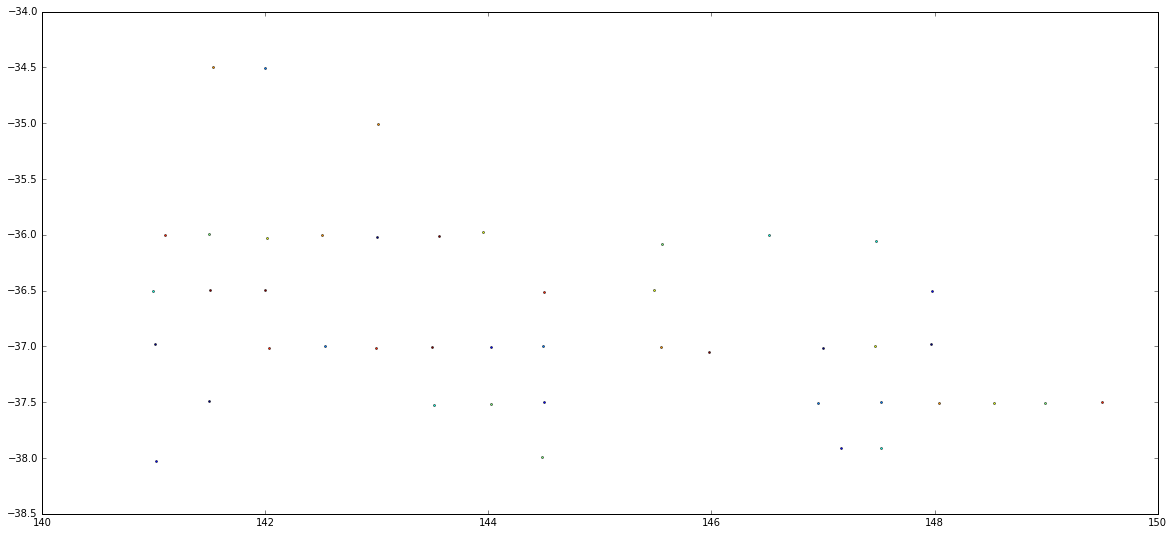

In [17]:
mygdf.plot()

In [22]:
mygdf2=mygdf.to_crs({'init':'epsg:28354'}) 
# WGS84: 'epsg:4326'

# GDA94:  EPSG:4283 See  http://epsg.io/4283

#http://spatialreference.org/ref/epsg/4283/


In [23]:
mygdf2.crs

{'init': 'epsg:28354'}

In [24]:
mygdf2utm=mygdf2.to_crs({'init':'epsg:28354'}) 

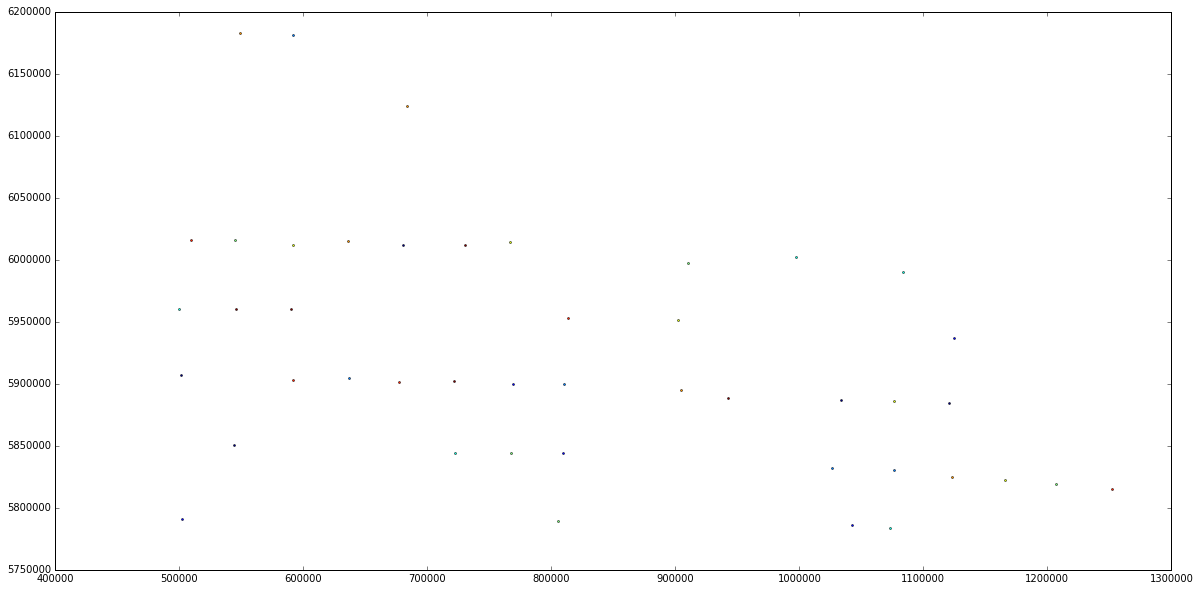

In [25]:
mygdf2utm.plot()

In [26]:
mygdf2utm.crs

{'init': 'epsg:28354'}

In [27]:
mygdf2utm.head()

,lat,lon,pendepths,geometry
0,-37.011650,146.99582,"11178.64,15586.27,17001.26,19556.92,21002.20,2...",POINT (1033672.625821199 5886990.621521201)
1,-36.506900,147.97250,"23020.78,24185.24,22480.17,30483.30,32678.48,3...",POINT (1124820.99091516 5937144.036274396)
2,-34.503671,141.99907,"1223.69,2262.37,3384.39,4955.46,6483.84,9472.9...",POINT (591715.5171486211 6181542.721844636)
3,-35.997830,146.51416,"7333.92,11513.01,17385.87,23848.26,26242.09,31...",POINT (997230.4377015287 6002203.815015243)
4,-37.505000,148.99190,"25808.96,28950.94,31354.15,39591.35,43364.65,5...",POINT (1206951.320797517 5818974.534747528)


# Reading Shape files

# Analyze and visualize the geodata

In [34]:
# #shpfile=r'E:\MT_shape_files\PT_0.8547s_WGS84.shp'
# shpfile=r'/Softlab/Data/MT_datasets/75099_Youanmi/Phase_Tensor_Shapes/PT_109.23s_WGS84.shp'
# shpfile=r'/Softlab/Data/MT_datasets/75098/Location_shapefile/YOM_MT_CDP.shp'

shapefile_list=[
    "/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YMB2.shp",
    "/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YMB1.shp",
    "/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YML.shp",
    "/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YNB3.shp",
    "/Softlab/Data/MT_Datasets/75098/Location_shapefile/YOM_MT_CDP.shp"
    ]

shp_list=[]
for shpfile in shapefile_list:
    print ("Processing shape file: %s",shpfile)

    shp_gpd=gpd.GeoDataFrame.from_file(shpfile)
    shp_list.append(shp_gpd)

    print(shp_gpd.shape, shp_gpd.columns)
    print("Projection: ", shp_gpd.crs)


('Processing shape file: %s', '/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YMB2.shp')
2017-03-25 15:41:09,722 - Fiona - INFO - Failed to auto identify EPSG: 7
((54, 5), Index([u'Altitude', u'Latitude', u'Longitude', u'Site', u'geometry'], dtype='object'))
('Projection: ', {u'no_defs': True, u'ellps': u'GRS80', u'proj': u'longlat'})
('Processing shape file: %s', '/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YMB1.shp')
2017-03-25 15:41:09,810 - Fiona - INFO - Failed to auto identify EPSG: 7
((59, 5), Index([u'Altitude', u'Latitude', u'Longitude', u'Site', u'geometry'], dtype='object'))
('Projection: ', {u'no_defs': True, u'ellps': u'GRS80', u'proj': u'longlat'})
('Processing shape file: %s', '/Softlab/Data/MT_Datasets/75099_Youanmi/Location_shapefiles/YML.shp')
2017-03-25 15:41:09,848 - Fiona - INFO - Failed to auto identify EPSG: 7
((49, 5), Index([u'Altitude', u'Latitude', u'Longitude', u'Site', u'geometry'], dtype='object'))
('Projection: ', {u'no_defs':

In [35]:


# the first 3 shape files are of the same structure, they can be joined well:
rdf = gpd.GeoDataFrame( pd.concat( shp_list[:3], ignore_index=True) )

# if include the 4'th shapoe file, which has different columns, the concat will produce a many more columns gpd!!!!!

In [36]:
rdf.shape

(162, 5)

In [37]:
rdf.columns

Index([u'Altitude', u'Latitude', u'Longitude', u'Site', u'geometry'], dtype='object')

In [38]:
rdf.head()

,Altitude,Latitude,Longitude,Site,geometry
0,463.0,-27.89623,120.84460,YMB141,POINT (120.8446 -27.896233)
1,431.0,-28.27168,118.31708,YMB062,POINT (118.31708 -28.271683)
2,434.0,-28.23312,118.33012,YMB063,POINT (118.33012 -28.233117)
3,445.0,-28.20348,118.31773,YMB064,POINT (118.31773 -28.203483)
4,455.0,-28.16203,118.32352,YMB065,POINT (118.32352 -28.162033)


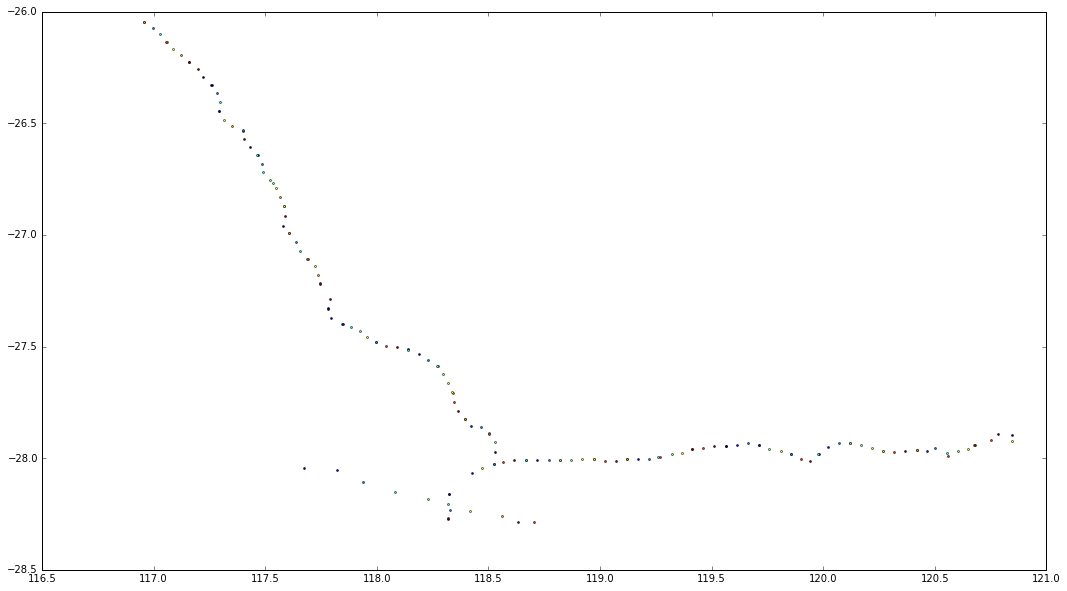

In [39]:
rdf.plot()

In [40]:

icount=4

shpf=shp_list[ icount ]

shpf.head()


,CDP_NO,FID_1,ID,POINT_NO,X,X_E,Y,Y_N,geometry
0,2000,None,BL01,1000,128.27279,426381,-25.04820,7229571,POINT (128.27279 -25.0482)
1,2500,None,B02,1250,128.17672,416971,-25.06974,7227080,POINT (128.17672 -25.06974)
2,3000,None,BL03,1500,128.11526,410585,-25.13284,7219968,POINT (128.11526 -25.13284)
3,3500,None,B04,1750,128.04230,403514,-25.19512,7213107,POINT (128.0423 -25.19512)
4,4000,None,BL05,2000,127.97280,396490,-25.25565,7206423,POINT (127.9728 -25.25565)


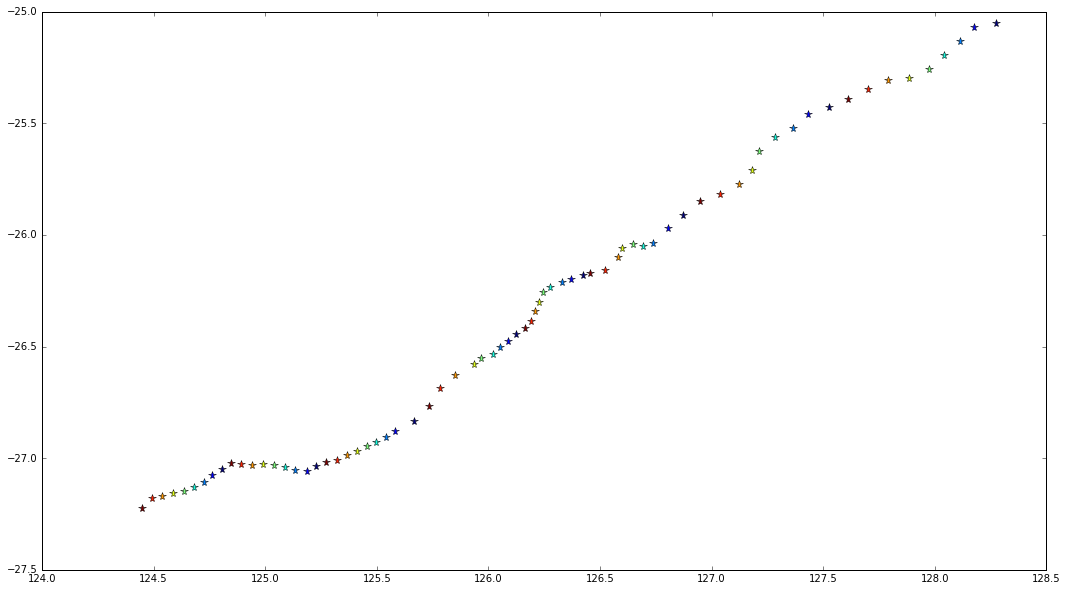

In [41]:
shpf.plot(marker='*', markersize=8)


# Re-Projecting

In [42]:
shpf.geometry.crs

{u'ellps': u'GRS80', u'no_defs': True, u'proj': u'longlat'}

In [43]:
# WGS84: 'epsg:4326'

# GDA94:  EPSG:4283 See  http://epsg.io/4283

#http://spatialreference.org/ref/epsg/4283/
    
myshpf= shpf.to_crs({'init':'epsg:4283'}) 


In [44]:
myshpf.geometry.crs

{'init': 'epsg:4283'}

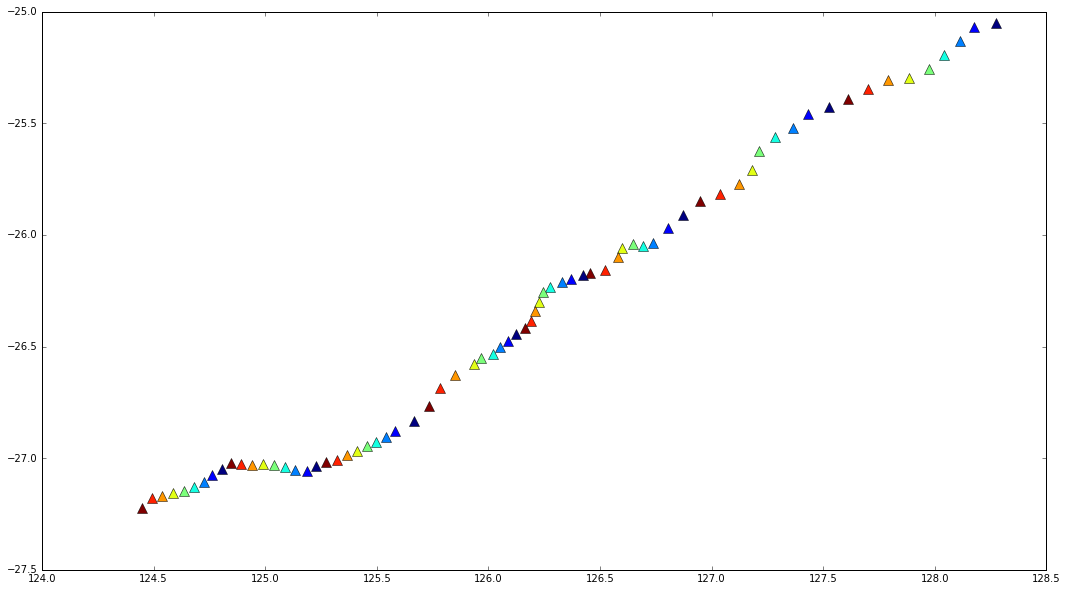

In [45]:
myshpf.plot(marker='^', markersize=10)


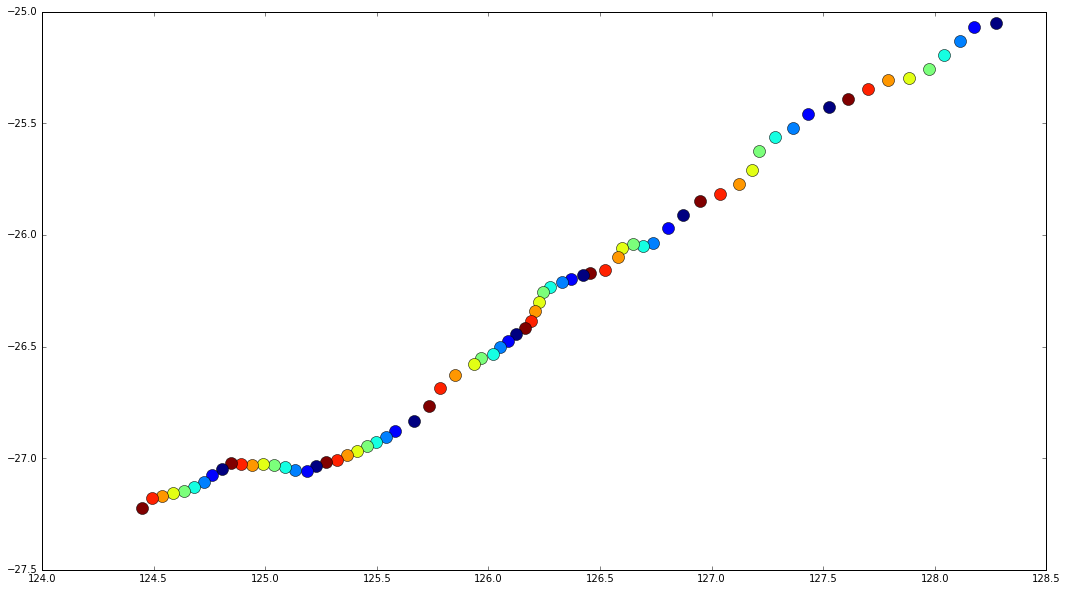

In [46]:
# Now, we create centroids and make it the geometry:

myshpf['centroid_column'] =myshpf.centroid

myshpf = myshpf.set_geometry('centroid_column')

myshpf.plot(marker='o', markersize='12');

In [47]:
myshpf.iloc[-2:]

,CDP_NO,FID_1,ID,POINT_NO,X,X_E,Y,Y_N,geometry,centroid_column
70,25446,None,B72,12940,124.49425,647747,-27.17930,6992656,POINT (124.49425 -27.1793),POINT (124.49425 -27.1793)
71,25600,None,BL73,13105,124.44778,642652,-27.22293,6987644,POINT (124.44778 -27.22293),POINT (124.44778 -27.22293)


In [48]:
myshpf['geometry'][:10]

0     POINT (128.27279 -25.0482)
1    POINT (128.17672 -25.06974)
2    POINT (128.11526 -25.13284)
3     POINT (128.0423 -25.19512)
4     POINT (127.9728 -25.25565)
5    POINT (127.88555 -25.29591)
6    POINT (127.78885 -25.30696)
7    POINT (127.70198 -25.34453)
8    POINT (127.61269 -25.39045)
9    POINT (127.52538 -25.42702)
Name: geometry, dtype: object

## Mapping onto World Basemap

In [49]:
# geopandas included shape datasets
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.shape

(177, 6)

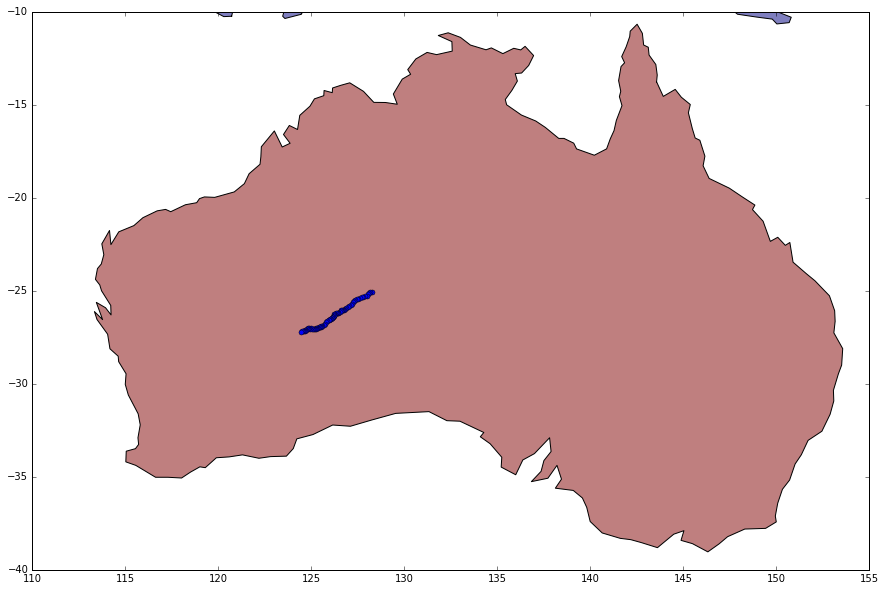

In [50]:


myax=world.plot(alpha=0.5)
#myax.set_xlim([149,150])
myax.set_xlim([110,155])
myax.set_ylim([-40,-10])
    
myax=myshpf.plot(ax=myax, figsize=(10, 6),  marker='o', color='blue', markersize=5);

In [52]:
# what if the crs are different in layers.
world.crs

{'init': u'epsg:4326'}

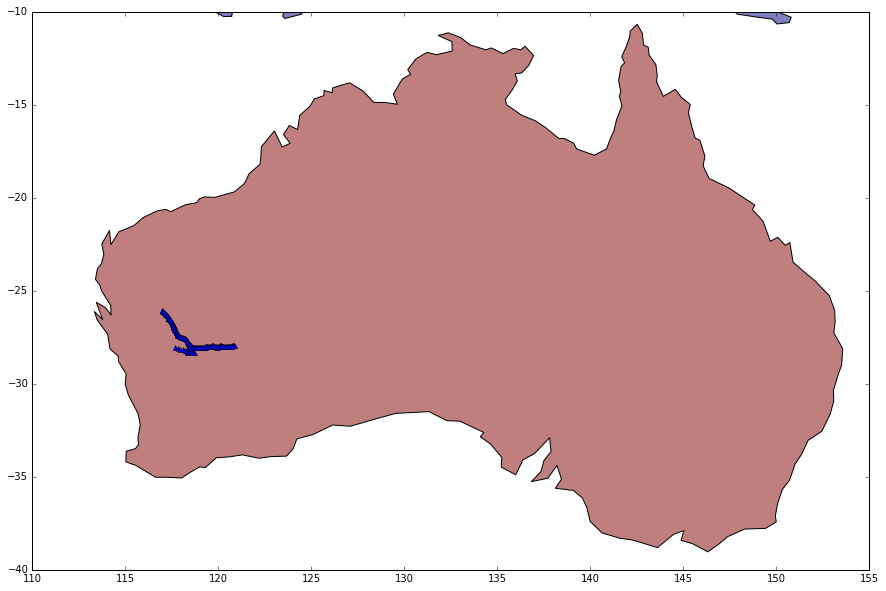

In [53]:
myax=world.plot(alpha=0.5)
#myax.set_xlim([149,150])
myax.set_xlim([110,155])
myax.set_ylim([-40,-10])

rdf.plot(ax=myax, figsize=(10, 6),  marker='^', color='blue', markersize=5);


# Mapping with Folium

In [54]:
# conda install folium

import folium

mapa = folium.Map([-30.0, 149.0], zoom_start=4,   tiles='cartodbpositron')


In [55]:
myshpf = myshpf.set_geometry('geometry')
myshp2json=myshpf.geometry.to_json()

points =folium.features.GeoJson(myshp2json)
mapa.add_children(points)

In [56]:
geoj2=shpf.to_crs(epsg=4326).to_json()

points2 =folium.features.GeoJson(geoj2)
mapa.add_children(points2)

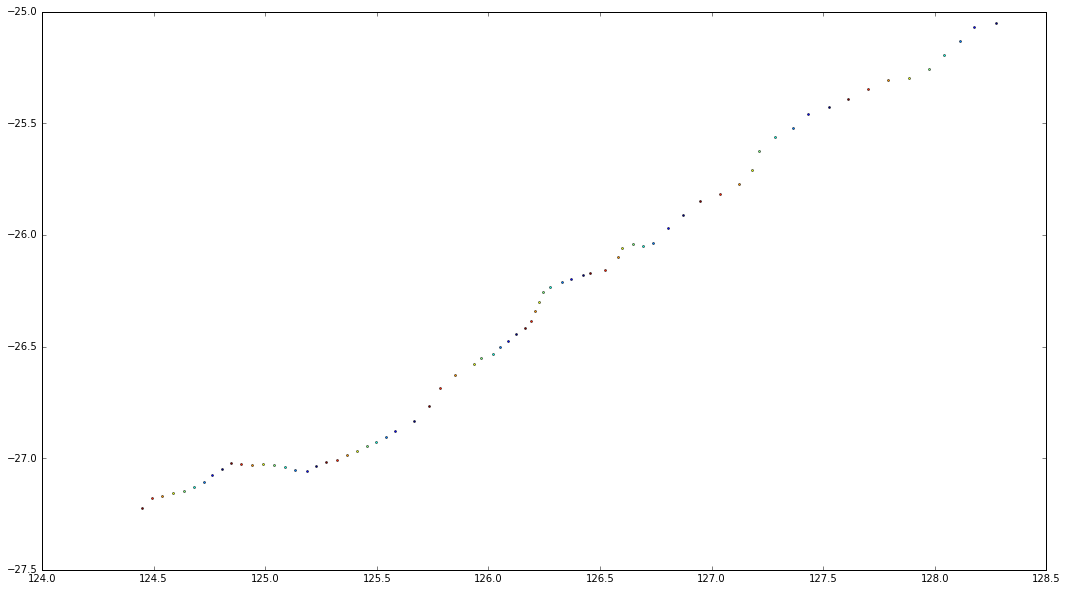

In [57]:
shpf3= shpf.to_crs({'init': 'epsg:4326'})
shpf3.plot()


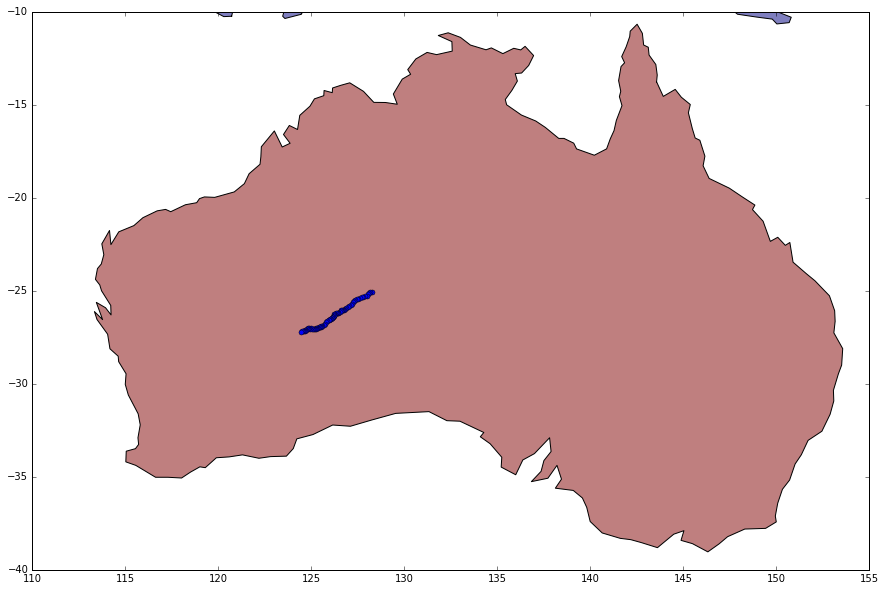

In [58]:
myax=world.plot(alpha=0.5)
#myax.set_xlim([149,150])
myax.set_xlim([110,155])
myax.set_ylim([-40,-10])
shpf3.plot(ax=myax, figsize=(10, 6),  marker='o', color='blue', markersize=5);

/e/Data/MT_Datasets/GA_UA_edited_10s-10000s/mt_survey_sites.shp
(45, 4)


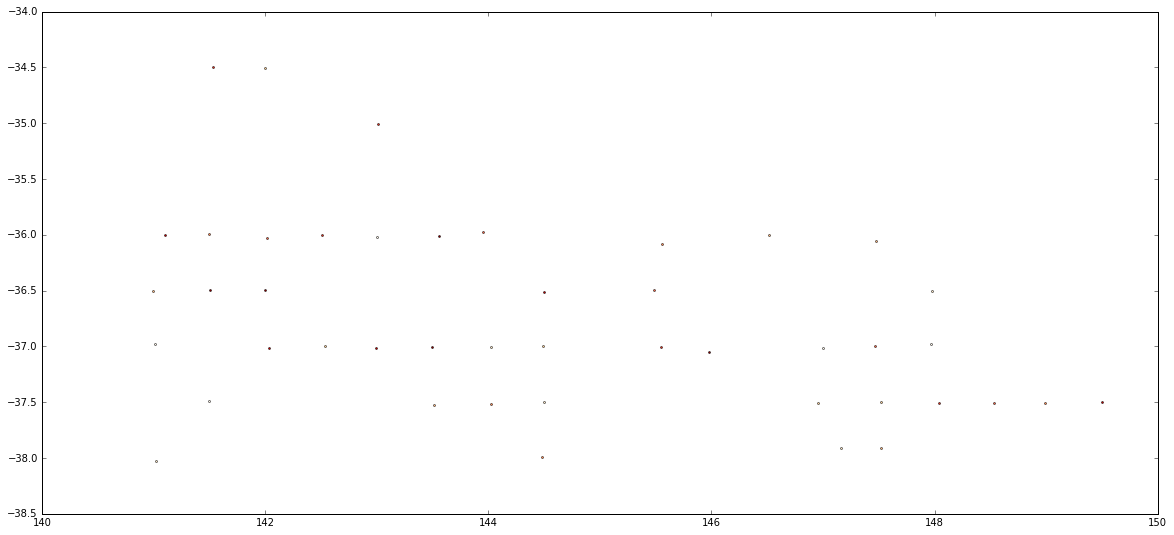

In [59]:
#Phase Tensor shape files and Tipper (Real/Imag) Shape Files

#shpfile=r'E:\MT_shape_files\Tip_1.4286s_WGS84_imag.shp'
#shpfile=r'/Softlab/Data/MT_datasets/728889/Phase_Tensor_Shapes/Tip_2s_WGS84_imag.shp'
shpfile=mt_survey_loc_shp

shpf=gpd.GeoDataFrame.from_file(shpfile)

#shpf['phi_max'].plot(marker='*', markersize=14)

shpf.plot(cmap='OrRd', scheme='quantiles');  #(marker='o', color='red', markersize=5)
print mt_survey_loc_shp
print shpf.shape